In [43]:
import sys
sys.path.insert(0,'../src')
sys.path.insert(0,'../data')
sys.path.insert(0,'../upload_data')
sys.path.insert(0,'../config')
sys.path.insert(0,'..')
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import etl
import json
import cleaning
import datetime
from heatmaps import *
import matplotlib.colors as colors
from get_date_range_df import *

In [2]:
%load_ext autoreload
%autoreload 2

In [28]:
%reload_ext autoreload

In [4]:
fp_2017 = '../data/raw/STOPS_2017.csv'
test_2017 = cleaning.clean_2017(fp_2017)
test_2017.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (5,7,8,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,1444799,Moving Violation,120,Native American,Male,37.0,2017-01-01,00:03:00,N,N,NaN,N,N
1,1444867,Equipment Violation,120,White,Male,24.0,2017-01-01,19:15:00,N,N,NaN,N,N
2,1444871,Equipment Violation,310,Other,Male,32.0,2017-01-01,19:10:00,N,N,NaN,N,N
3,1444869,Moving Violation,620,White,Male,31.0,2017-01-01,19:10:00,N,N,NaN,N,N
4,1444888,Moving Violation,710,Hispanic/Latino/a,Female,67.0,2017-01-01,18:50:00,N,N,NaN,N,N


In [5]:
fp_2018 = '../data/raw/STOPS_2018-2019.csv'
test_2018 = cleaning.clean_2018_2019(fp_2018)
test_2018.head()

,stop_id,stop_cause,beat,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,2443,Reasonable Suspicion,122,120,White,Male,25,2018-07-01,00:01:37,Y,N,NaN,N,N
1,2444,Traffic Violation,121,120,White,Male,25,2018-07-01,00:03:34,N,N,NaN,N,N
2,2447,Reasonable Suspicion,822,820,Hispanic/Latino/a,Male,30,2018-07-01,00:05:43,N,N,NaN,N,N
3,2448,Traffic Violation,614,610,White,Male,23,2018-07-01,00:19:06,N,N,NaN,N,N
4,2449,Reasonable Suspicion,115,110,White,Male,25,2018-07-01,00:03:00,Y,Y,NaN,N,N


In [10]:
areas = make_areas()
areas

,serv,geometry
0,930,"MULTIPOLYGON (((6268975.465 1931147.469, 62689..."
1,0,"MULTIPOLYGON (((6261648.576 1836846.672, 62616..."
2,510,"MULTIPOLYGON (((6261640.429 1836823.561, 62616..."
3,720,"POLYGON ((6302781.000 1793246.001, 6302905.000..."
4,310,"POLYGON ((6284667.652 1874418.895, 6284694.392..."
...,...,...
135,240,"POLYGON ((6295777.084 1908435.558, 6295790.126..."
136,930,"POLYGON ((6295209.132 1952772.422, 6295208.647..."
137,930,"POLYGON ((6287497.113 1936631.116, 6287462.453..."
138,230,"POLYGON ((6306176.245 1943421.146, 6306158.416..."


In [16]:
make_proportions(test,'Asian','2018-07-01','2018-10-15')

,prop
service_area,
110,0.389007
120,0.408492
230,0.311028
240,0.435225
310,0.734200
320,0.577301
430,0.288547
440,0.438810
510,0.318795


In [29]:
from dateutil.relativedelta import relativedelta

In [33]:
def make_heat(df,race,event,start_date,end_date):
    areas = make_areas()
    props = make_proportions(df,race,start_date,end_date)
    heat = areas.merge(props, left_on='serv',right_index=True, how='outer')
    heat = heat.dissolve(by='serv',aggfunc='first').fillna(0).drop(0)
    event_y = (datetime.date.fromisoformat(start_date) + relativedelta(months = 2)).year
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.axis('off')
    ax.set_title(f'Proportion of {race} Drivers Stopped By Service Area\n Event: {event} ({event_y})'.format(race,event,event_y), fontdict={'fontsize':'15','fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=heat.prop.max()))
    fig.colorbar(sm)
    heat.plot(column='prop', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

2018

In [68]:
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'green': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

In [90]:
def make_difference_heatmap(df_current,df_prior,race,event,start_date,end_date):
    areas = make_areas()
    prior_start_date = (datetime.date.fromisoformat(start_date)-relativedelta(years=1)).isoformat()
    prior_end_date = (datetime.date.fromisoformat(end_date)-relativedelta(years=1)).isoformat()
    props_post = make_proportions(df_current,race,start_date,end_date)
    props_pre = make_proportions(df_prior,race,prior_start_date,prior_end_date)
    differences = props_post.subtract(props_pre)
    heat_diff = areas.merge(differences, left_on='serv',right_index=True, how='outer')
    heat_diff = heat_diff.dissolve(by='serv',aggfunc='first').fillna(0).drop(0)
    event_y = (datetime.date.fromisoformat(start_date) + relativedelta(months = 2)).year
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.axis('off')
    ax.set_title(f'Proportion of {race} Drivers Stopped By Service Area\n Event: {event} ({event_y})'.format(race,event,event_y), fontdict={'fontsize':'15','fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=-1, vmax=1))
    fig.colorbar(sm)
    heat_diff.plot(column='prop', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8')
    return heat_diff


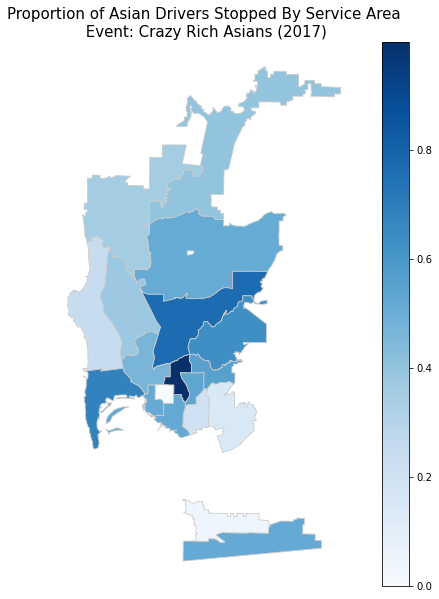

In [19]:
make_heat(test_2017,'Asian','Crazy Rich Asians','2017-07-01','2017-10-15',save_fig=True)

/Users/Nathan/heatmap_visualizations


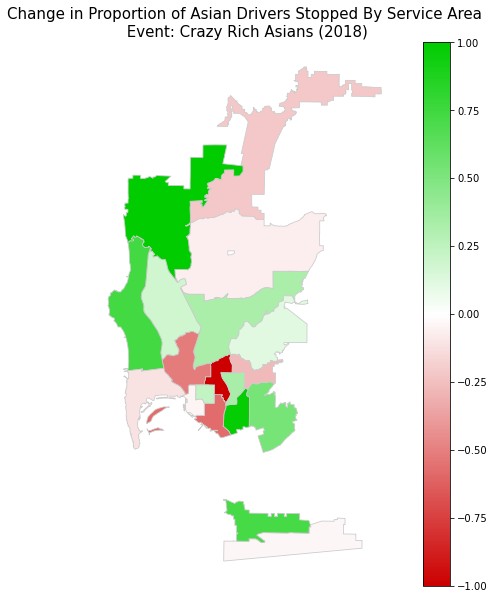

In [21]:
make_difference_heatmap(test_2018,test_2017,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15',save_fig=True)

In [36]:
test_2017

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,1444799,Moving Violation,120,Native American,Male,37.0,2017-01-01,00:03:00,N,N,NaN,N,N
1,1444867,Equipment Violation,120,White,Male,24.0,2017-01-01,19:15:00,N,N,NaN,N,N
2,1444871,Equipment Violation,310,Other,Male,32.0,2017-01-01,19:10:00,N,N,NaN,N,N
3,1444869,Moving Violation,620,White,Male,31.0,2017-01-01,19:10:00,N,N,NaN,N,N
4,1444888,Moving Violation,710,Hispanic/Latino/a,Female,67.0,2017-01-01,18:50:00,N,N,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137690,1619683,Moving Violation,610,White,Female,43.0,NaN,NaN,N,N,NaN,N,N
137691,1620010,Moving Violation,720,Hispanic/Latino/a,Male,27.0,NaN,NaN,N,N,NaN,N,N
137692,1620015,Moving Violation,810,White,Male,31.0,NaN,NaN,N,N,NaN,N,N
137693,1620007,Moving Violation,710,Hispanic/Latino/a,Male,56.0,NaN,NaN,N,N,NaN,N,N


In [57]:
test_2015

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,1191287,Moving Violation,430,White,Female,NaN,2015-01-01,NaN,N,N,NaN,N,N
1,1191295,Moving Violation,520,Black/African American,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
2,1191275,Moving Violation,430,Black/African American,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
3,1191308,Moving Violation,520,White,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
4,1191285,Moving Violation,430,White,Female,NaN,2015-01-01,NaN,N,N,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115417,1308165,Moving Violation,Unknown,Hispanic/Latino/a,Female,38.0,2015-12-31,23:39,N,N,NaN,N,N
115418,1308166,Equipment Violation,930,White,Male,18.0,2015-12-31,23:40,N,N,NaN,N,N
115419,1308168,Moving Violation,520,Black/African American,Male,38.0,2015-12-31,23:52,N,N,NaN,N,N
115420,1308169,Equipment Violation,830,Black/African American,Female,33.0,2015-12-31,23:54,N,N,NaN,N,N


In [54]:
fp_2016 = '../data/raw/STOPS_2016.csv'
test_2016 = cleaning.clean_2014_2016(fp_2016)
fp_2015 = '../data/raw/STOPS_2015.csv'
test_2015 = cleaning.clean_2014_2016(fp_2015)
fp_2014 = '../data/raw/STOPS_2014.csv'
test_2014 = cleaning.clean_2014_2016(fp_2014)

(None, None)

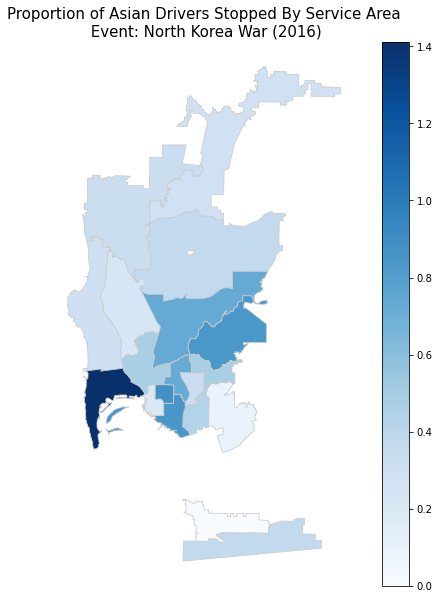

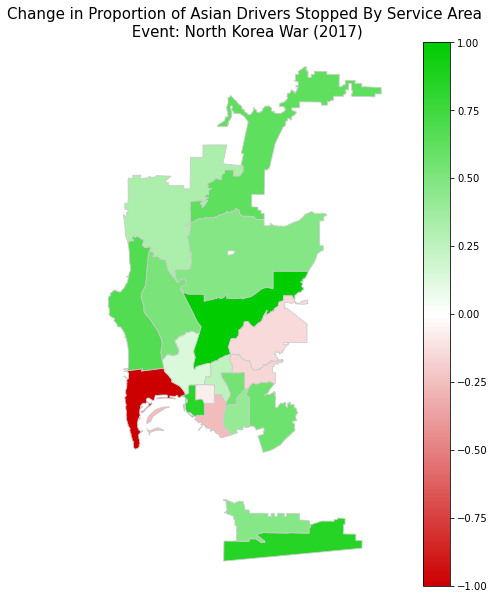

In [89]:
(make_heat(test_2016,'Asian','North Korea War','2016-02-01','2016-06-01',save_fig=True),
 make_difference_heatmap(test_2017,test_2016,
                         'Asian','North Korea War','2017-02-01','2017-06-01',save_fig=True))




(None, None)

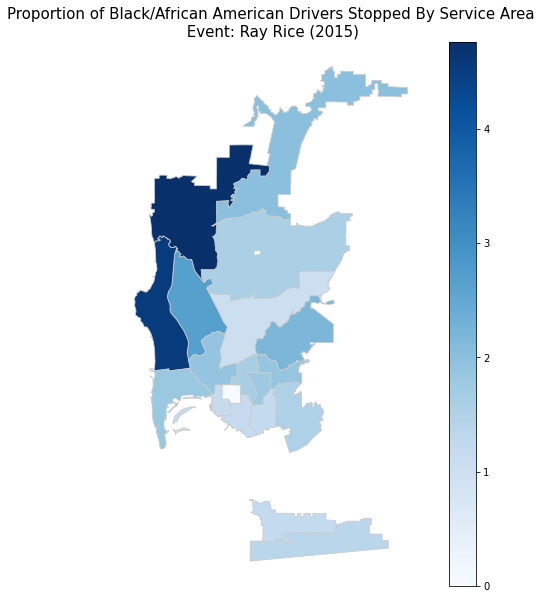

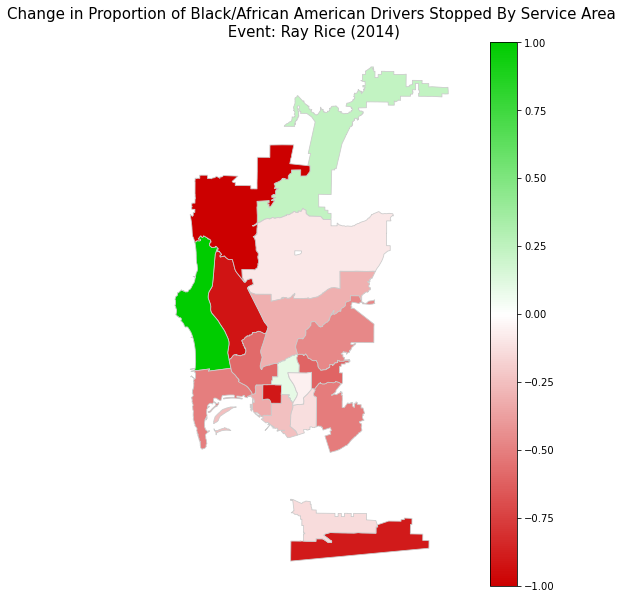

In [87]:
(make_heat(test_2015,'Black/African American','Ray Rice','2015-07-08','2015-11-08',save_fig=True),
 make_difference_heatmap(test_2014,test_2015,'Black/African American','Ray Rice','2014-07-28','2014-11-28',save_fig=True))
    

In [80]:
make_num(test_2015,'Black/African American','2015-7-28','2015-11-28')

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized


In [79]:
test_2015[[(pd.to_datetime(x) >= pd.to_datetime('2015-7-28')) & (pd.to_datetime(x) <= pd.to_datetime('2015-11-28')) for x in test_2015.date_stop]]

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
70045,1263015,Moving Violation,520,Hispanic/Latino/a,Male,73.0,2015-07-28,3:45,N,N,NaN,N,N
70046,1263010,Moving Violation,440,Hispanic/Latino/a,Male,22.0,2015-07-28,4:55,Y,Y,NaN,N,N
70047,1263013,Moving Violation,520,White,Male,46.0,2015-07-28,9:10,N,N,NaN,N,N
70048,1263012,Moving Violation,430,Black/African American,Male,31.0,2015-07-28,9:20,N,N,NaN,N,N
70049,1263002,Moving Violation,520,White,Female,42.0,2015-07-28,9:25,N,N,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106087,1298635,"Suspect Info (I.S., Bulletin, Log)",520,Hispanic/Latino/a,Male,26.0,2015-11-28,23:20,N,N,NaN,N,N
106088,1298633,Equipment Violation,830,Hispanic/Latino/a,Female,24.0,2015-11-28,23:30,N,N,N,N,N
106089,1299732,Moving Violation,520,White,Male,18.0,2015-11-28,23:30,N,N,NaN,N,N
106090,1298631,Moving Violation,230,White,Female,50.0,2015-11-28,23:35,N,N,NaN,N,N


In [73]:
test_2015

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,1191287,Moving Violation,430,White,Female,NaN,2015-01-01,NaN,N,N,NaN,N,N
1,1191295,Moving Violation,520,Black/African American,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
2,1191275,Moving Violation,430,Black/African American,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
3,1191308,Moving Violation,520,White,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
4,1191285,Moving Violation,430,White,Female,NaN,2015-01-01,NaN,N,N,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115417,1308165,Moving Violation,Unknown,Hispanic/Latino/a,Female,38.0,2015-12-31,23:39,N,N,NaN,N,N
115418,1308166,Equipment Violation,930,White,Male,18.0,2015-12-31,23:40,N,N,NaN,N,N
115419,1308168,Moving Violation,520,Black/African American,Male,38.0,2015-12-31,23:52,N,N,NaN,N,N
115420,1308169,Equipment Violation,830,Black/African American,Female,33.0,2015-12-31,23:54,N,N,NaN,N,N
